In [49]:
import sys
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt,pi
import matplotlib.pyplot as plt
import math
import datetime
from scipy import stats
import seaborn as sns
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,RidgeCV,LassoCV,ElasticNetCV
from sklearn.metrics import mean_squared_error
import random




In [15]:
van = pd.read_csv('listings.csv.gz')

In [26]:
van.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2911 entries, 0 to 4322
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   latitude              2911 non-null   float64
 1   longitude             2911 non-null   float64
 2   price                 2911 non-null   float64
 3   bedrooms              2911 non-null   float64
 4   host_neighbourhood    2911 non-null   object 
 5   number_of_reviews     2911 non-null   int64  
 6   review_scores_rating  2911 non-null   float64
 7   property_type         2911 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 204.7+ KB


In [18]:
van = van[['latitude','longitude','price','bedrooms','host_neighbourhood','number_of_reviews','review_scores_rating','property_type']]

In [22]:
van = van.dropna()

In [25]:
## Have to convert price from currency object to float
## CONVERT STRING DOLLAR SIGN TO FLOAT 
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

van['price'] = van['price'].apply(clean_currency).astype('float')

## Exploratory Analysis 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

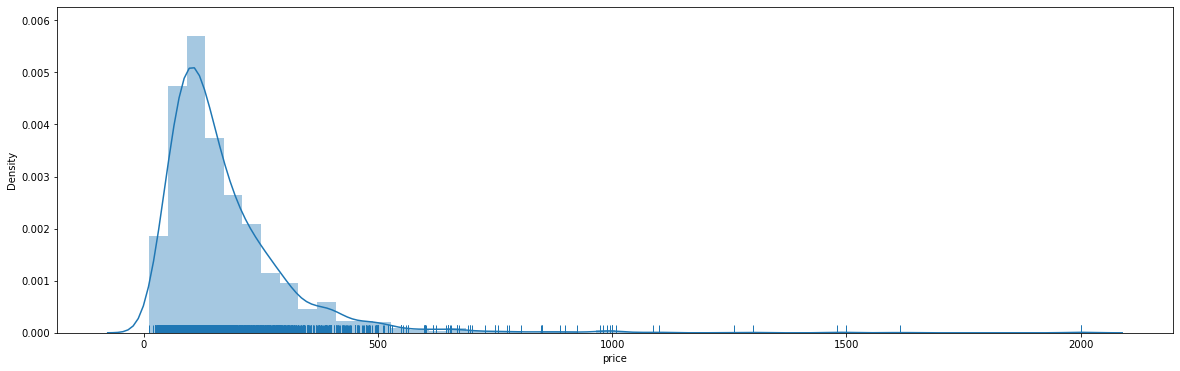

In [28]:
plt.figure(figsize=(20,6))
sns.distplot(van['price'],rug=True)

<AxesSubplot:title={'center':'price'}, xlabel='property_type'>

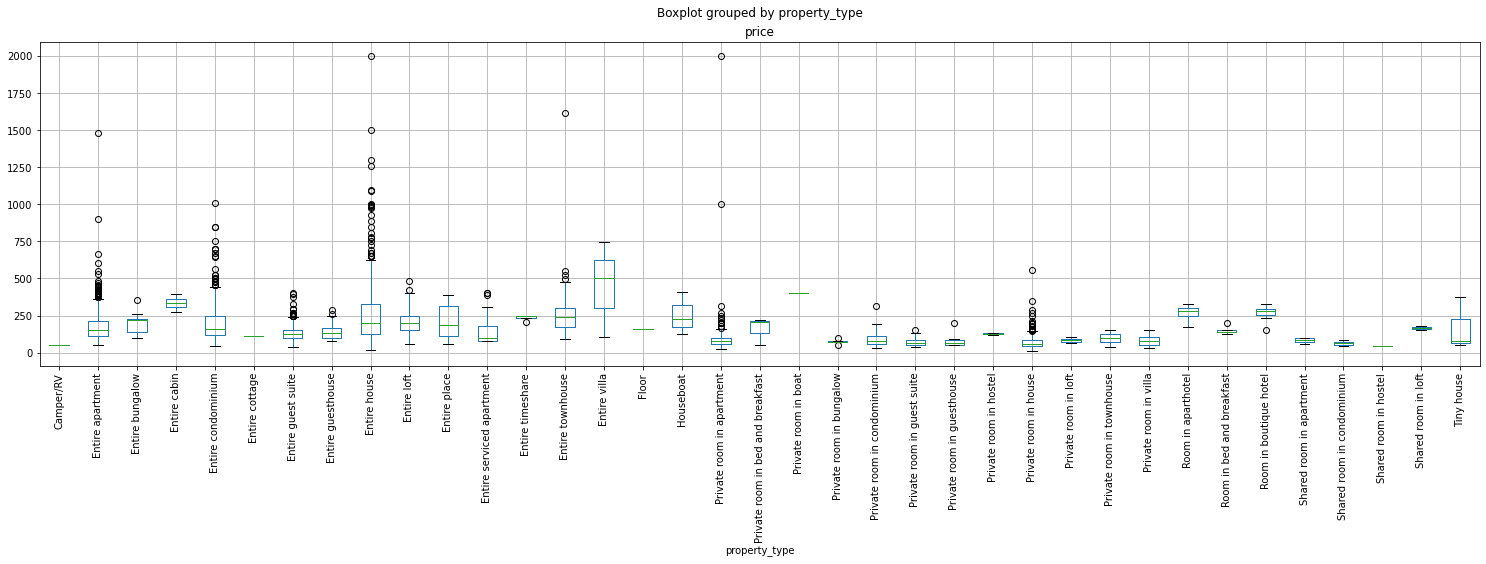

In [29]:
## box plot comparing price with room type 
van.boxplot(column='price',by='property_type',figsize=(25,6),rot=90)


<AxesSubplot:title={'center':'price'}, xlabel='host_neighbourhood'>

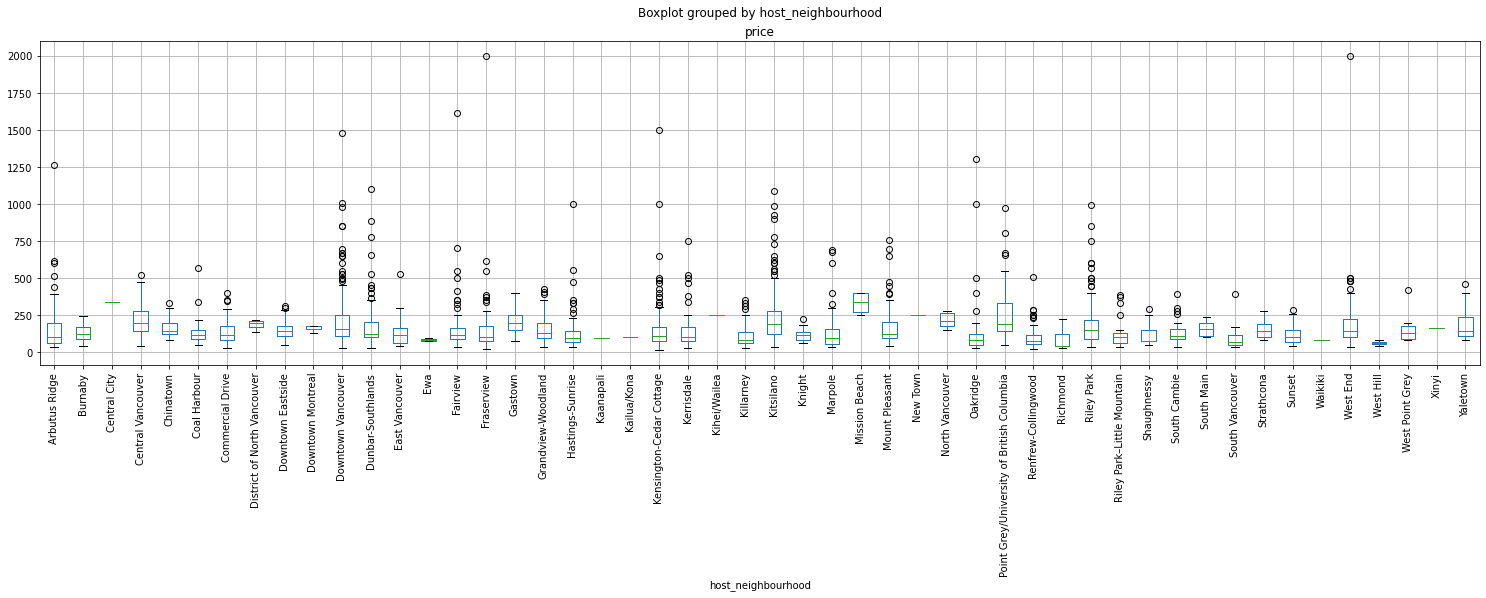

In [30]:
## box plot comparing price neighborhood type
van.boxplot(column='price',by='host_neighbourhood',figsize=(25,6),rot=90)   

In [36]:
van.describe()


,latitude,longitude,price,bedrooms,number_of_reviews,review_scores_rating
count,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000
mean,49.263232,-123.111155,174.651666,1.593610,40.148746,4.721597
std,0.019505,0.038510,146.198186,0.874661,62.388420,0.566714
min,49.202960,-123.217570,12.000000,1.000000,1.000000,0.000000
25%,49.250900,-123.129330,90.000000,1.000000,4.000000,4.680000
50%,49.267310,-123.114620,135.000000,1.000000,16.000000,4.860000
75%,49.279145,-123.087390,215.500000,2.000000,51.000000,5.000000
max,49.294360,-123.022480,2000.000000,8.000000,662.000000,5.000000


In [38]:
print(sorted(van['host_neighbourhood'].unique())) ## Sorted Neigborhoods
print(len(van['host_neighbourhood'].unique())) ## number of Neighborhoods
## I think i am loosing the orignal number of neigborhoods of 61 when removing nulls NEED TO REVISIT 

['Arbutus Ridge', 'Burnaby', 'Central City', 'Central Vancouver', 'Chinatown', 'Coal Harbour', 'Commercial Drive', 'District of North Vancouver', 'Downtown Eastside', 'Downtown Montreal', 'Downtown Vancouver', 'Dunbar-Southlands', 'East Vancouver', 'Ewa', 'Fairview', 'Fraserview', 'Gastown', 'Grandview-Woodland', 'Hastings-Sunrise', 'Kaanapali', 'Kailua/Kona', 'Kensington-Cedar Cottage', 'Kerrisdale', 'Kihei/Wailea', 'Killarney', 'Kitsilano', 'Knight', 'Marpole', 'Mission Beach', 'Mount Pleasant', 'New Town', 'North Vancouver', 'Oakridge', 'Point Grey/University of British Columbia', 'Renfrew-Collingwood', 'Richmond', 'Riley Park', 'Riley Park–Little Mountain', 'Shaughnessy', 'South Cambie', 'South Main', 'South Vancouver', 'Strathcona', 'Sunset', 'Waikiki', 'West End', 'West Hill', 'West Point Grey', 'Xinyi', 'Yaletown']
50


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

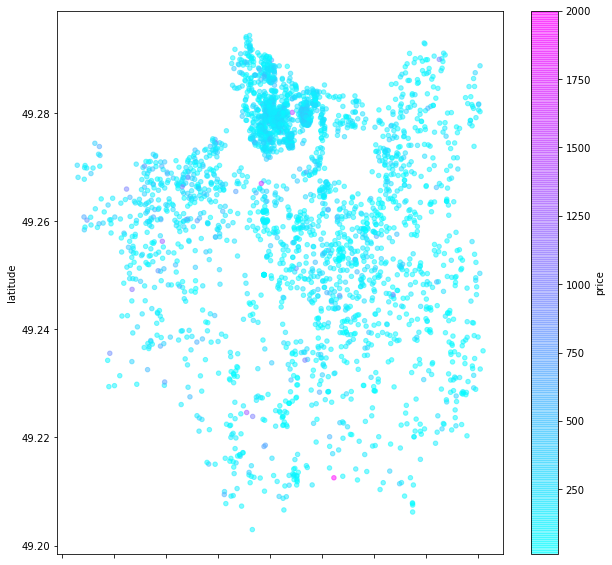

In [39]:

van.plot.scatter(x='longitude',y='latitude',c='price',figsize=(10,10),cmap='cool',alpha=0.5)
## NEED TO LOWER THE PRICE SINCE THE EXPENSIVE ONES ARE NOT VISIBLE BECAUSE OF THE OUTLIERS

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

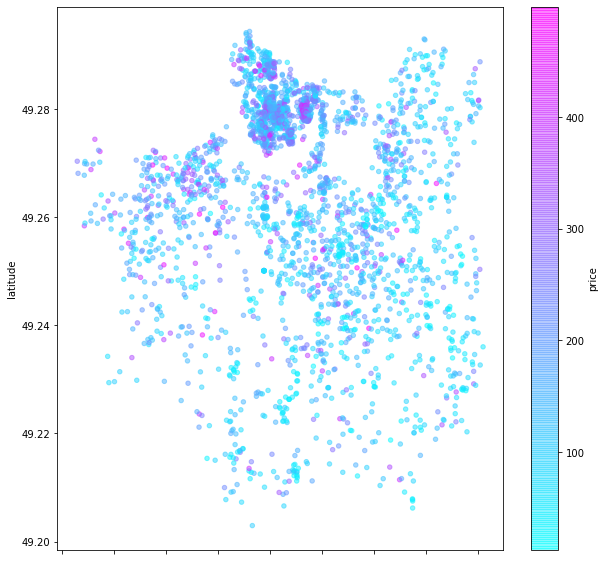

In [40]:
van[van['price']<500].plot.scatter(x='longitude',y='latitude',c='price',figsize=(10,10),cmap='cool',alpha=0.5)
## EXPENSIVE ONES ARE SCATTERED 

## REVIEWS 

<AxesSubplot:xlabel='review_scores_rating', ylabel='price'>

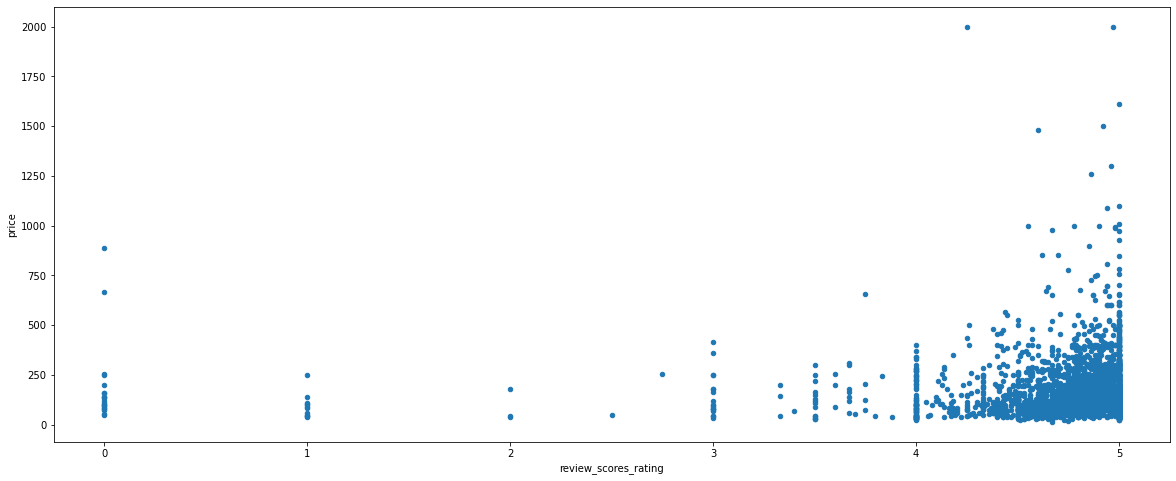

In [41]:
van.plot.scatter(x='review_scores_rating',y='price',figsize=(20,8))

<AxesSubplot:xlabel='number_of_reviews', ylabel='price'>

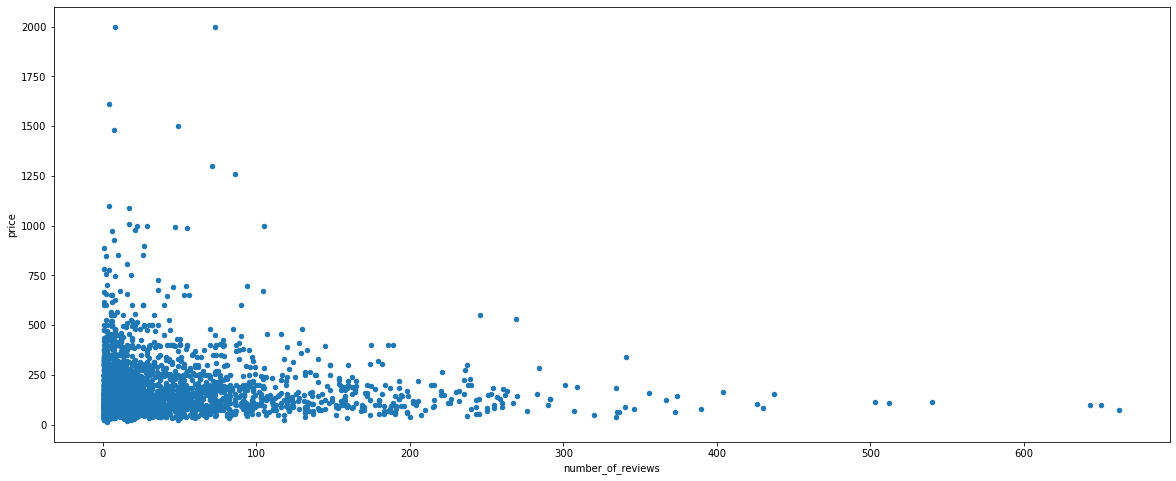

In [42]:
van.plot.scatter(x='number_of_reviews',y='price',figsize=(20,8))


## BEDROOMS 

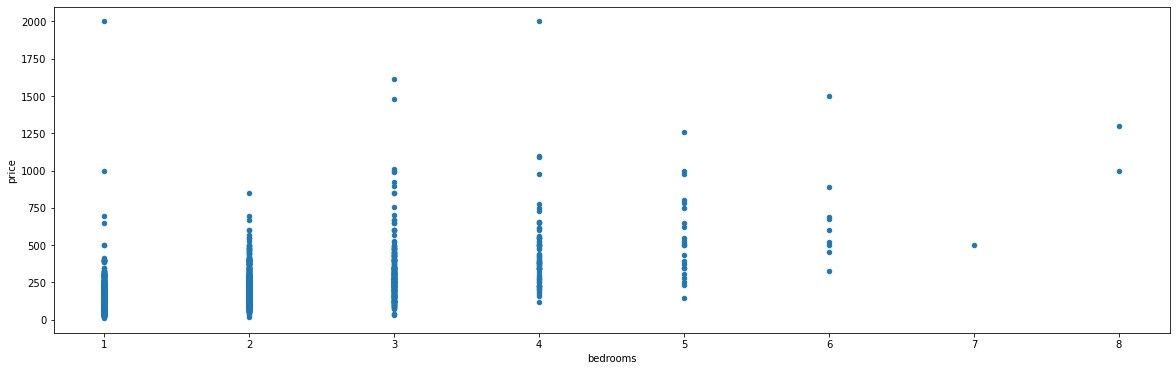

In [43]:
van.plot.scatter(x='bedrooms',y='price',figsize=(20,6));
## DOES NOT TELL US MUCH 

## Modelling


In [44]:
data = van.copy()
data = pd.get_dummies(data) ## We have to encode the neigborhood into encoded variables 
data.head()

,latitude,longitude,price,bedrooms,number_of_reviews,review_scores_rating,host_neighbourhood_Arbutus Ridge,host_neighbourhood_Burnaby,host_neighbourhood_Central City,host_neighbourhood_Central Vancouver,...,property_type_Private room in townhouse,property_type_Private room in villa,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Shared room in apartment,property_type_Shared room in condominium,property_type_Shared room in hostel,property_type_Shared room in loft,property_type_Tiny house
0,49.28872,-123.12046,150.0,2.0,16,4.64,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,49.28201,-123.12669,85.0,1.0,430,4.67,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,49.25622,-123.06607,140.0,1.0,89,4.91,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,49.24922,-123.08139,150.0,1.0,33,4.75,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,49.27721,-123.04086,195.0,2.0,5,4.80,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
X = data.copy().drop('price',axis = 1)
y = data['price'].copy()

In [48]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y)

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_valid)

In [54]:
baseline = y_train.median()
baseline_error = np.sqrt(mean_squared_error(y_pred=np.ones_like(y_valid)* baseline,y_true = y_valid))
baseline_error

157.0325436978583

### Standard error of +/- 157.03 for the prices of AirBnb

## Machine learning

In [57]:
from sklearn.ensemble import RandomForestClassifier ##Random Forest Model 
classifier = RandomForestClassifier(n_estimators=100,max_depth=3, min_samples_leaf=10)
results = classifier.fit(X_train_scaled,y_train)

In [73]:
test_score = results.score(X_test_scaled,y_valid)


In [72]:
from sklearn import svm

clf = svm.SVC()
results2 = clf.fit(X_train_scaled,y_train)
test_score2 = results2.score(X_test_scaled,y_valid)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

baseline = y_train.median() #median train
print('If we just take the median value, our baseline, we would say that an overnight stay in Vancouver costs: ' + str(baseline))


baseline_error = np.sqrt(mean_squared_error(y_pred=np.ones_like(y_test) * baseline, y_true=y_test))
print('And we will be right +- ' + str(baseline_error))

If we just take the median value, our baseline, we would say that an overnight stay in Vancouver costs: 134.0
And we will be right +- 138.36154165370957


In [71]:
lr = LinearRegression()
alphas = [1000, 100, 50, 20, 10, 1, 0.1, 0.01]
l1_ratios = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
ridge = RidgeCV(alphas=alphas)
lasso = LassoCV(alphas=alphas, max_iter=10000)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)

for model, name in zip([lr, ridge, lasso, elastic], ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']):
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    mrse_train = np.sqrt(mean_squared_error(y_pred=y_pred_train, y_true=y_train))
    y_pred = model.predict(X_test_scaled)
    mrse_test = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
    best_alpha = ''
    if name != 'LinearRegression':
        best_alpha = ' best alpha: ' + str(model.alpha_)
    best_l1 = ''
    if name == 'ElasticNet':
        best_l1 = ' best l1: '+ str(model.l1_ratio_)
    print(name + ' mrse_train: ' + str(mrse_train) + ', mrse_test: ' + str(mrse_test) + best_alpha + best_l1)

LinearRegression mrse_train: 112.31730703786397, mrse_test: 62849548131049.33
Ridge mrse_train: 112.38335131674286, mrse_test: 94.55700483781465 best alpha: 100.0
Lasso mrse_train: 112.60871011809911, mrse_test: 93.80714244538807 best alpha: 1.0
ElasticNet mrse_train: 113.01227985562676, mrse_test: 93.93807156995445 best alpha: 1.0 best l1: 0.9


## Linear Regression gives a terrible error 
## Ridge we get a reasonable result 
## Lasso gives the best answer 